Overview of the project - 
Separates toxic and clean comments from the dataset.
Randomly samples 15,000 clean comments to create a balanced dataset.
Tokenizes the comments, encodes labels, and creates data loaders for training.
Fine-tunes the BERT model for classification on the balanced dataset.
Saves the trained model for future use.

### Step1: Pre-requisites

!pip install transformers
!pip install torch

### Step2: Importing libraries 

In [1]:
import numpy as np
import pandas as pd

#data visualisation libraries
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams

import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score

#to avoid warnings
import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

### Step 3: Load and Preprocess the Dataset

In [2]:
import os
import zipfile

directory_path = '/kaggle/input/jigsaw-toxic-comment-classification-challenge'
files_in_directory = os.listdir(directory_path)
print(files_in_directory)

for files in files_in_directory:
    # Path to the zip file
    zip_file_path = directory_path+'/'+files
    # Directory where you want to extract the contents
    output_dir = '/kaggle/working/'

    # Unzip the file
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(output_dir)

['train.csv.zip', 'sample_submission.csv.zip', 'test_labels.csv.zip', 'test.csv.zip']


In [3]:
data = pd.read_csv("/kaggle/working/train.csv")
print(data.head())

                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  
0             0        0       0       0              0  
1             0        0       0       0              0  
2             0        0       0       0              0  
3             0        0       0       0              0  
4             0        0       0       0              0  


### Step4: Data Visualization to Understand Class Distribution

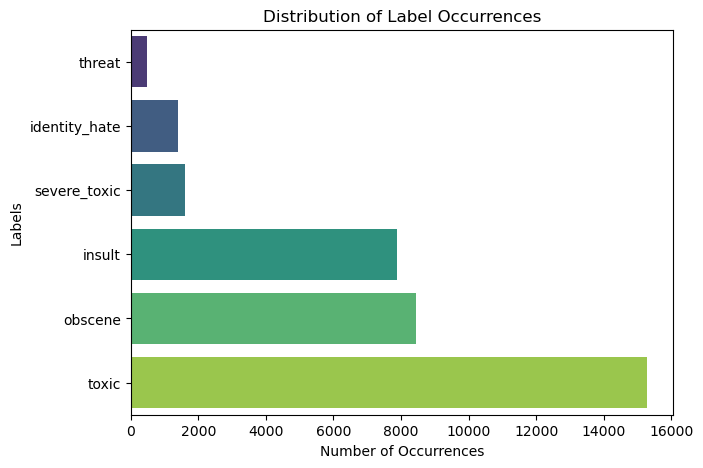

In [4]:
# Visualizing the class distribution of the 'label' column
column_labels = data.columns.tolist()[2:]
label_counts = data[column_labels].sum().sort_values()


# Create a black background for the plot
plt.figure(figsize=(7, 5))  

# Create a horizontal bar plot using Seaborn
ax = sns.barplot(x=label_counts.values, y=label_counts.index, palette='viridis')


# Add labels and title to the plot
plt.xlabel('Number of Occurrences')  
plt.ylabel('Labels')  
plt.title('Distribution of Label Occurrences') 

# Show the plot
plt.show()

In [5]:
data[column_labels].sum().sort_values()

threat             478
identity_hate     1405
severe_toxic      1595
insult            7877
obscene           8449
toxic            15294
dtype: int64

### Step5: Handling class imbalance 

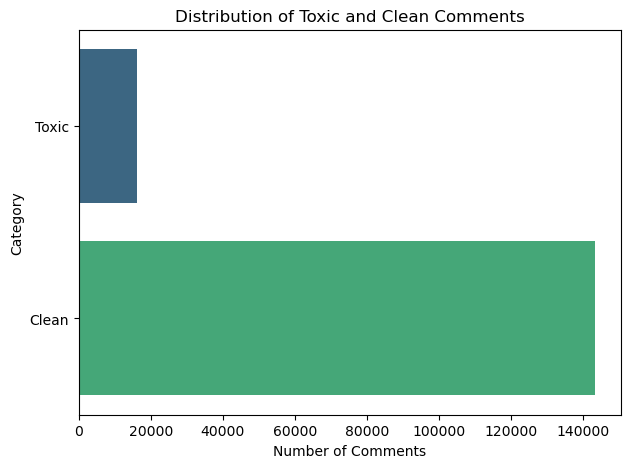

In [6]:
# Create subsets based on toxic and clean comments
train_toxic = data[data[column_labels].sum(axis=1) > 0]
train_clean = data[data[column_labels].sum(axis=1) == 0]

# Number of toxic and clean comments
num_toxic = len(train_toxic)
num_clean = len(train_clean)

# Create a DataFrame for visualization
plot_data = pd.DataFrame({'Category': ['Toxic', 'Clean'], 'Count': [num_toxic, num_clean]})

# Create a black background for the plot
plt.figure(figsize=(7, 5))

# Horizontal bar plot 
ax = sns.barplot(x='Count', y='Category', data=plot_data, palette='viridis')


# Add labels and title to the plot
plt.xlabel('Number of Comments')
plt.ylabel('Category')
plt.title('Distribution of Toxic and Clean Comments')

# Set ticks' color to white
ax.tick_params()

# Show the plot
plt.show()

In [7]:
print(train_toxic.shape)
print(train_clean.shape)

(16225, 8)
(143346, 8)


Note: To handle the imbalanced data, we can create a new training set in which the number of toxic comments remains the same, and to match that, we will randomly sample 15,000 clean comments and include them in the training set

#### New balanced dataframe

In [8]:
train_clean.shape

(143346, 8)

In [9]:
# Randomly sample 15,000 clean comments
train_clean_sampled = train_clean.sample(n=16225, random_state=42)

# Combine the toxic and sampled clean comments 
df = pd.concat([train_toxic, train_clean_sampled], axis=0)

# Shuffle the data to avoid any order bias during training
df  = df.sample(frac=1, random_state=42)

In [10]:
data[column_labels].sum().sort_values()

threat             478
identity_hate     1405
severe_toxic      1595
insult            7877
obscene           8449
toxic            15294
dtype: int64

In [11]:
df[column_labels].sum().sort_values()

threat             478
identity_hate     1405
severe_toxic      1595
insult            7877
obscene           8449
toxic            15294
dtype: int64

In [12]:
print(train_toxic.shape)
print(train_clean_sampled.shape)
print(df.shape)

(16225, 8)
(16225, 8)
(32450, 8)


### Step7 : Fine-tune BERT Model for Multilabel Classification

#### Tokenization & encoding using BertTokenizer

In [13]:
# Token and Encode Function
def tokenize_and_encode(tokenizer, comments, labels, max_length=128):
    input_ids = []
    attention_masks = []

    for comment in comments:
        encoded_dict = tokenizer.encode_plus(
            comment,
            add_special_tokens=True,
            max_length=max_length,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels, dtype=torch.float32)

    return input_ids, attention_masks, labels

In [14]:
# Token and Encode Function
def tokenize_and_encode(tokenizer, comments, labels, max_length=128):
    # Initialize empty lists to store tokenized inputs and attention masks
    input_ids = []
    attention_masks = []

    # Iterate through each comment in the 'comments' list
    for comment in comments:
        
        # Tokenize and encode the comment using the BERT tokenizer
        encoded_dict = tokenizer.encode_plus(
            comment,
            # Add special tokens like [CLS] and [SEP]
            add_special_tokens=True,      
            # Truncate or pad the comment to 'max_length'
            max_length=max_length,      
            # Pad the comment to 'max_length' with zeros if needed
            pad_to_max_length=True,    
            # Return attention mask to mask padded tokens
            return_attention_mask=True, 
            # Return PyTorch tensors
            return_tensors='pt')

        # Append the tokenized input and attention mask to their respective lists
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    # Concatenate the tokenized inputs and attention masks into tensors
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    # Convert the labels to a PyTorch tensor with the data type float32
    labels = torch.tensor(labels, dtype=torch.float32)

    # Return the tokenized inputs, attention masks, and labels as PyTorch tensors
    return input_ids, attention_masks, labels

In [15]:
# Token Initialization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Model Initialization
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=6)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

In [16]:
# Move model to GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model =model.to(device)

### Step6: Split the dataset 

In [17]:
# Split data into training, testing sets & validation sets 
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['comment_text'], df.iloc[:, 2:], test_size=0.3,stratify=True, random_state=42)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:2                                                                                    │
│                                                                                                  │
│   1 # Split data into training, testing sets & validation sets                                   │
│ ❱ 2 train_texts, test_texts, train_labels, test_labels = train_test_split(                       │
│   3 │   df['comment_text'], df.iloc[:, 2:], test_size=0.3,stratify=True, random_state=42)        │
│   4                                                                                              │
│                                                                                                  │
│ /opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:2583 in                │
│ train_test_split                                                                                 │
│                                                                                                  │
│   2580 │   │                                                                                     │
│   2581 │   │   cv = CVClass(test_size=n_test, train_size=n_train, random_state=random_state)     │
│   2582 │   │                                                                                     │
│ ❱ 2583 │   │   train, test = next(cv.split(X=arrays[0], y=stratify))                             │
│   2584 │                                                                                         │
│   2585 │   return list(                                                                          │
│   2586 │   │   chain.from_iterable(                                                              │
│                                                                                                  │
│ /opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:2160 in split          │
│                                                                                                  │
│   2157 │   │   split. You can make the results identical by setting `random_state`               │
│   2158 │   │   to an integer.                                                                    │
│   2159 │   │   """                                                                               │
│ ❱ 2160 │   │   y = check_array(y, input_name="y", ensure_2d=False, dtype=None)                   │
│   2161 │   │   return super().split(X, y, groups)                                                │
│   2162                                                                                           │
│   2163                                                                                           │
│                                                                                                  │
│ /opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:929 in check_array           │
│                                                                                                  │
│    926 │   │   │   )                                                                             │
│    927 │                                                                                         │
│    928 │   if ensure_min_samples > 0:                                                            │
│ ❱  929 │   │   n_samples = _num_samples(array)                                                   │
│    930 │   │   if n_samples < ensure_min_samples:                                                │
│    931 │   │   │   raise ValueError(                                                             │
│    932 │   │   │   │   "Found array with %d sample(s) (shape=%s) while a"                        │
│                                                                                                  │
│ /opt/conda/lib/python3.10/site-packages/sklearn/utils/valid

In [ ]:
#validation set
test_texts, val_texts, test_labels, val_labels = train_test_split(
    test_texts, test_labels, test_size=0.5, random_state=42)

In [ ]:
# Tokenize and Encode the comments and labels for the training set
input_ids, attention_masks, labels = tokenize_and_encode(
    tokenizer, 
    train_texts, 
    train_labels.values
)

In [ ]:
# Step 4: Tokenize and Encode the comments and labels for the test set
test_input_ids, test_attention_masks, test_labels = tokenize_and_encode(
    tokenizer,
    test_texts,
    test_labels.values
)

In [ ]:
# Tokenize and Encode the comments and labels for the validation set
val_input_ids, val_attention_masks, val_labels = tokenize_and_encode(
    tokenizer,
    val_texts,
    val_labels.values
)

#### Creating DataLoaders for training dataset

In [ ]:
# Creating DataLoader for the balanced dataset
batch_size = 32
train_dataset = TensorDataset(input_ids, attention_masks, labels)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

#test
test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_labels)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#val
val_dataset = TensorDataset(val_input_ids, val_attention_masks, val_labels)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

#### Initialising optimizer
Initializes the optimizer for training the model 

Adam with Weight Decay (AdamW) is a variant of the Adam optimizer that incorporates weight decay (L2 regularization) during the parameter updates. It is an extension of the original Adam optimizer and addresses some of its limitations when using weight decay as a regularization technique.

In [ ]:
# Optimizer setup
optimizer = AdamW(model.parameters(), lr=2e-5)

### Step8: Model training 

In [ ]:
# Function to Train the Model
def train_model(model, train_loader, optimizer, device, num_epochs):
    # Loop through the specified number of epochs
    for epoch in range(num_epochs):
        # Set the model to training mode
        model.train() 
        # Initialize total loss for the current epoch
        total_loss = 0  

        # Loop through the batches in the training data
        for batch in train_loader:
            input_ids, attention_mask, labels = [t.to(device) for t in batch]

            optimizer.zero_grad()

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()

            loss.backward()
            optimizer.step()

        model.eval()  # Set the model to evaluation mode
        val_loss = 0

        # Disable gradient computation during validation
        with torch.no_grad():
            for batch in val_loader:
                input_ids, attention_mask, labels = [t.to(device) for t in batch]

                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                val_loss += loss.item()
        # Print the average loss for the current epoch
        print(f'Epoch {epoch+1}, Training Loss: {total_loss/len(train_loader)},Validation loss:{val_loss/len(val_loader)}')

# Call the function to train the model
train_model(model, train_loader, optimizer, device, num_epochs=3)

### Step9: Model Evaluation 

In [ ]:
# Evaluate the Model
def evaluate_model(model, test_loader, device):
    model.eval()  # Set the model to evaluation mode

    true_labels = []
    predicted_probs = []

    with torch.no_grad():
        for batch in test_loader:
            input_ids, attention_mask, labels = [t.to(device) for t in batch]

            # Get model's predictions
            outputs = model(input_ids, attention_mask=attention_mask)
            predicted_probs_batch = torch.sigmoid(outputs.logits)  # Use sigmoid for multilabel classification
            predicted_probs.append(predicted_probs_batch.cpu().numpy())

            true_labels_batch = labels.cpu().numpy()
            true_labels.append(true_labels_batch)

    # Combine predictions and labels for evaluation
    true_labels = np.concatenate(true_labels, axis=0)
    predicted_probs = np.concatenate(predicted_probs, axis=0)
    predicted_labels = (predicted_probs > 0.5).astype(int)  # Apply threshold for binary classification

    # Calculate evaluation metrics
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels, average='micro')
    recall = recall_score(true_labels, predicted_labels, average='micro')

    # Print the evaluation metrics
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')

# Call the function to evaluate the model on the test data
evaluate_model(model, test_loader, device)

## Save the model

In [ ]:
# Save the tokenizer and model in the same directory
output_dir = "/kaggle/working/Saved_model"
model.save_pretrained(output_dir)  # Save model's state dictionary and configuration
tokenizer.save_pretrained(output_dir)  # Save tokenizer's configuration and vocabulary

## Load the model

In [ ]:
# Load the tokenizer and model from the saved directory
model_name ="/kaggle/working/Saved_model"
Bert_Tokenizer = BertTokenizer.from_pretrained(model_name)
Bert_Model = BertForSequenceClassification.from_pretrained(model_name).to(device)

### Prediction for user input

In [ ]:
def predict_user_input(input_text, model=Bert_Model, tokenizer=Bert_Tokenizer,device=device):
    user_input = [input_text]

    user_encodings = tokenizer(user_input, truncation=True, padding=True, return_tensors="pt")

    user_dataset = TensorDataset(user_encodings['input_ids'], user_encodings['attention_mask'])

    user_loader = DataLoader(user_dataset, batch_size=1, shuffle=False)

    model.eval()
    with torch.no_grad():
        for batch in user_loader:
            input_ids, attention_mask = [t.to(device) for t in batch]
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            predictions = torch.sigmoid(logits)

    predicted_labels = (predictions.cpu().numpy() > 0.5).astype(int)
    labels_list = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
    result = dict(zip(labels_list, predicted_labels[0]))
    return result
text = 'Are you insane!'
predict_user_input(input_text=text)

In [ ]:
predict_user_input(input_text='How are you?')

#### let's test it 

In [ ]:
input_text = 'You are insane'
predict_user_input(input_text)

In [ ]:
text = "Such a Idiot person"
predict_user_input(model=Bert_Model, 
                   tokenizer=Bert_Tokenizer,
                   input_text=text, 
                   device=device)

In [ ]:
text = "I'll kill you"
predict_user_input(model=Bert_Model, 
                   tokenizer=Bert_Tokenizer,
                   input_text=text, 
                   device=device)

In [ ]:
text = "I'll kill you"
predict_user_input(model=Bert_Model, 
                   tokenizer=Bert_Tokenizer,
                   input_text=text, 
                   device=device)